In [1]:
%load_ext jupyter_black
import torch
import torch.optim as optim
import torch.nn as nn
from optimizers.lsgd import LSGD
from optimizers.lrmsprop import LRMSprop
from optimizers.ladam import LAdam
from optimizers.ladadelta import LAdadelta
from optimizers.lsgd import APLSGD
import matplotlib.pyplot as plt
import numpy as np
import scienceplots
import tqdm
import math
from training.train import train, plot_langevin_loss
from diffusion.fishing import Fishing
from scheduler import PiecewiseConstantScheduler

plt.style.use(["science", "no-latex", "grid"])

seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
train_batch = 512
test_batch = 512
train_size = 5
test_size = 25
epochs = 50

## Single control:

In [3]:
def test_diag_single_ctrl(
    model_config,
    N_euler,
    control_config,
    optim,
    langevin_optim,
    name,
    lr,
    target_lr,
    sigma,
    epochs,
    total_iters,
    **optim_kwargs,
):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

    for i, N in enumerate(N_euler):
        # Vanilla algo
        ocp = Fishing(**model_config, N_euler=N)
        ocp.set_control(control_config, multiple_controls=False)
        vanilla_optim = optim(ocp.control.parameters(), lr=lr, **optim_kwargs)
        scheduler = PiecewiseConstantScheduler(
            vanilla_optim, target_lr=target_lr, target_sigma=0, total_iters=total_iters
        )
        train_loss, test_loss, test_ci = train(
            ocp,
            vanilla_optim,
            scheduler,
            name,
            epochs,
            train_size,
            test_size,
            train_batch,
            test_batch,
        )
        axs[i].plot(
            np.arange(len(test_loss)), test_loss, marker="o", mec="k", ms=3, label=name
        )
        axs[i].fill_between(
            np.arange(len(test_loss)),
            np.array(test_loss) - np.array(test_ci),
            np.array(test_loss) + np.array(test_ci),
            alpha=0.2,
        )

        # Langevin algo
        ocp = Fishing(**model_config, N_euler=N)
        ocp.set_control(control_config, multiple_controls=False)
        loptim = langevin_optim(ocp.control.parameters(), lr=lr, sigma=sigma[i])
        scheduler = PiecewiseConstantScheduler(
            loptim, target_lr=target_lr, target_sigma=0, total_iters=total_iters
        )
        train_loss, test_loss, test_ci = train(
            ocp,
            loptim,
            scheduler,
            f"L-{name}",
            epochs,
            train_size,
            test_size,
            train_batch,
            test_batch,
        )
        axs[i].plot(
            np.arange(len(test_loss)),
            test_loss,
            marker="o",
            mec="k",
            ms=3,
            label=f"L-{name}",
        )
        axs[i].fill_between(
            np.arange(len(test_loss)),
            np.array(test_loss) - np.array(test_ci),
            np.array(test_loss) + np.array(test_ci),
            alpha=0.2,
        )

        if i == 0:
            axs[i].set_ylabel(r"$J(u_\theta)$")
        axs[i].set_xlabel("Epochs")
        if i == 2:
            legend = axs[i].legend(fancybox=True, edgecolor="k", loc=0)
            legend.get_frame().set_linewidth(0.5)

    plt.show()
    plt.close()

    return fig

In [4]:
dim = 5

model_config = dict(
    T=1.0,
    dim=dim,
    r=2 * torch.ones(dim),
    kappa=torch.Tensor(
        [
            [1.2, -0.1, 0.0, 0.0, -0.1],
            [0.2, 1.2, 0.0, 0.0, -0.1],
            [0.0, 0.2, 1.2, -0.1, 0.0],
            [0.0, 0.0, 0.1, 1.2, 0.0],
            [0.1, 0.1, 0.0, 0.0, 1.2],
        ]
    ),
    X_d=torch.ones(dim),
    u_m=0.01,
    u_M=1.0,
    alpha=0.01 * torch.ones(dim),
    beta=0.1,
    sigma=0.1 * torch.eye(dim),
    init_mean=torch.ones(dim),
    init_std=0.5,
    init_lbound=0.2,
    init_ubound=2,
)

control_config = dict(
    input_dim=1 + dim,
    output_dim=dim,
    hidden_dim=32,
    depth=2,
    activation=nn.ReLU(),
    out_transform=nn.Sigmoid(),
)

Fishing: Epoch 49, Adam, lr=0.000, sigma=[0], train=0.323, test=0.325: 100%|██████████| 50/50 [00:09<00:00,  5.13it/s]
Fishing: Epoch 49, L-Adam, lr=0.000, sigma=[0], train=0.300, test=0.297: 100%|██████████| 50/50 [00:08<00:00,  5.81it/s]    
Fishing: Epoch 49, Adam, lr=0.000, sigma=[0], train=0.359, test=0.352: 100%|██████████| 50/50 [00:13<00:00,  3.69it/s]
Fishing: Epoch 49, L-Adam, lr=0.000, sigma=[0], train=0.284, test=0.287: 100%|██████████| 50/50 [00:14<00:00,  3.57it/s]    
Fishing: Epoch 49, Adam, lr=0.000, sigma=[0], train=0.339, test=0.337: 100%|██████████| 50/50 [00:27<00:00,  1.84it/s]
Fishing: Epoch 49, L-Adam, lr=0.000, sigma=[0], train=0.290, test=0.288: 100%|██████████| 50/50 [00:27<00:00,  1.80it/s]    


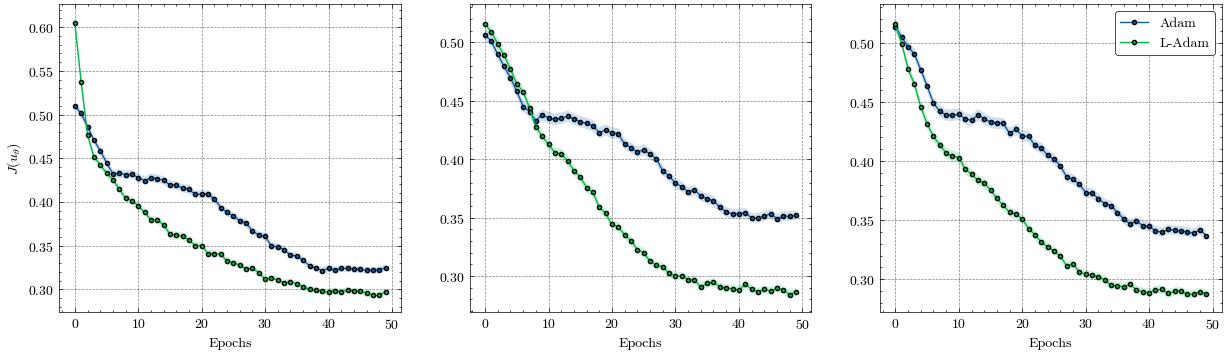

In [5]:
adam_single_ctrl = test_diag_single_ctrl(
    model_config,
    [30, 50, 100],
    control_config,
    torch.optim.Adam,
    LAdam,
    "Adam",
    2e-3,
    2e-4,
    [1e-3, 1e-3, 1e-3],
    50,
    40,
)

Training Fishing with RMSprop:   0%|          | 0/50 [00:00<?, ?it/s]

Fishing: Epoch 49, RMSprop, lr=0.000, sigma=[0], train=0.293, test=0.296: 100%|██████████| 50/50 [00:08<00:00,  5.93it/s]
Fishing: Epoch 49, L-RMSprop, lr=0.000, sigma=[0], train=0.285, test=0.277: 100%|██████████| 50/50 [00:08<00:00,  5.77it/s]    
Fishing: Epoch 49, RMSprop, lr=0.000, sigma=[0], train=0.302, test=0.301: 100%|██████████| 50/50 [00:14<00:00,  3.55it/s]
Fishing: Epoch 49, L-RMSprop, lr=0.000, sigma=[0], train=0.285, test=0.290: 100%|██████████| 50/50 [00:14<00:00,  3.49it/s]    
Fishing: Epoch 49, RMSprop, lr=0.000, sigma=[0], train=0.311, test=0.304: 100%|██████████| 50/50 [00:27<00:00,  1.80it/s]
Fishing: Epoch 49, L-RMSprop, lr=0.000, sigma=[0], train=0.291, test=0.288: 100%|██████████| 50/50 [00:27<00:00,  1.81it/s]    


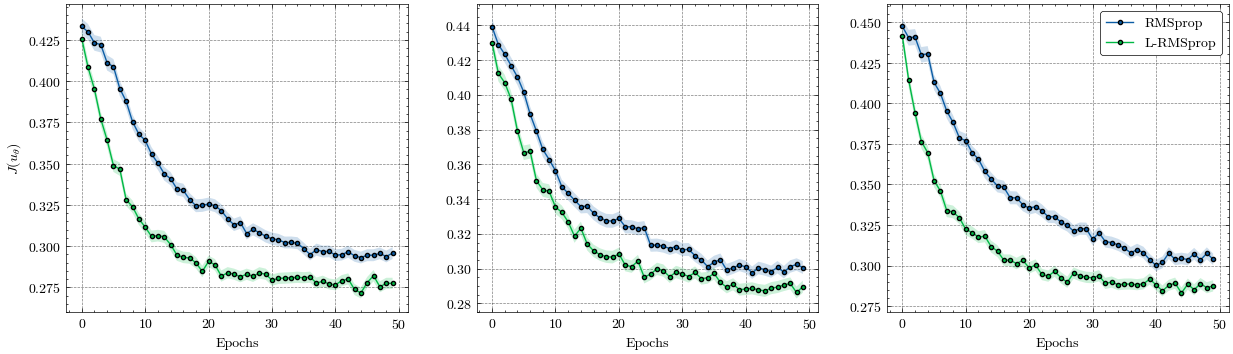

In [6]:
rmsprop_single_ctrl = test_diag_single_ctrl(
    model_config,
    [30, 50, 100],
    control_config,
    torch.optim.RMSprop,
    LRMSprop,
    "RMSprop",
    2e-3,
    2e-4,
    [5e-3, 5e-3, 5e-3],
    50,
    40,
)

Training Fishing with Adadelta:   0%|          | 0/50 [00:00<?, ?it/s]

Fishing: Epoch 49, Adadelta, lr=0.050, sigma=[0], train=0.427, test=0.425: 100%|██████████| 50/50 [00:07<00:00,  6.40it/s]
Fishing: Epoch 49, L-Adadelta, lr=0.050, sigma=[0], train=0.283, test=0.278: 100%|██████████| 50/50 [00:07<00:00,  6.35it/s]   
Fishing: Epoch 49, Adadelta, lr=0.050, sigma=[0], train=0.431, test=0.433: 100%|██████████| 50/50 [00:12<00:00,  3.91it/s]
Fishing: Epoch 49, L-Adadelta, lr=0.050, sigma=[0], train=0.283, test=0.284: 100%|██████████| 50/50 [00:13<00:00,  3.84it/s]   
Fishing: Epoch 49, Adadelta, lr=0.050, sigma=[0], train=0.428, test=0.439: 100%|██████████| 50/50 [00:25<00:00,  1.94it/s]
Fishing: Epoch 49, L-Adadelta, lr=0.050, sigma=[0], train=0.292, test=0.285: 100%|██████████| 50/50 [00:26<00:00,  1.91it/s]   


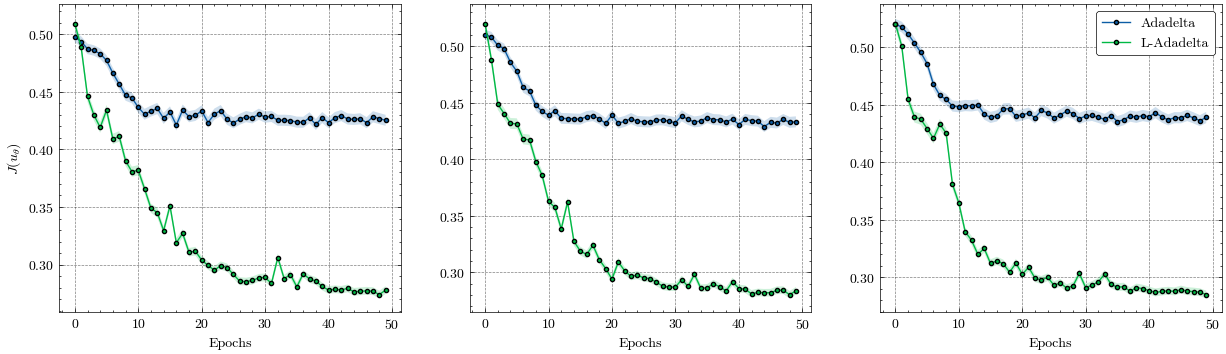

In [7]:
adadelta_single_ctrl = test_diag_single_ctrl(
    model_config,
    [30, 50, 100],
    control_config,
    torch.optim.Adadelta,
    LAdadelta,
    "Adadelta",
    5e-1,
    5e-2,
    [1e-2, 1e-2, 1e-2],
    50,
    40,
    rho=0.95,
)

Fishing: Epoch 49, SGD, lr=0.005, sigma=[0], train=0.426, test=0.426: 100%|██████████| 50/50 [00:07<00:00,  6.33it/s]
Fishing: Epoch 49, L-SGD, lr=0.005, sigma=[0], train=0.384, test=0.381: 100%|██████████| 50/50 [00:07<00:00,  6.39it/s]    
Fishing: Epoch 49, SGD, lr=0.005, sigma=[0], train=0.443, test=0.436: 100%|██████████| 50/50 [00:12<00:00,  3.85it/s]
Fishing: Epoch 49, L-SGD, lr=0.005, sigma=[0], train=0.393, test=0.391: 100%|██████████| 50/50 [00:13<00:00,  3.77it/s]    
Fishing: Epoch 49, SGD, lr=0.005, sigma=[0], train=0.437, test=0.444: 100%|██████████| 50/50 [00:27<00:00,  1.81it/s]
Fishing: Epoch 49, L-SGD, lr=0.005, sigma=[0], train=0.376, test=0.374: 100%|██████████| 50/50 [00:27<00:00,  1.85it/s]    


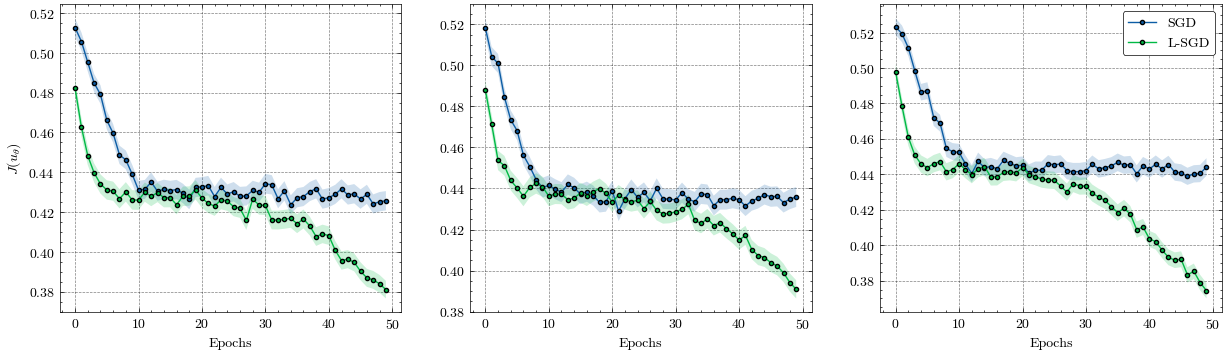

In [8]:
sgd_single_ctrl = test_diag_single_ctrl(
    model_config,
    [30, 50, 100],
    control_config,
    torch.optim.SGD,
    APLSGD,
    "SGD",
    5e-2,
    5e-3,
    [1e-3, 1e-3, 1e-3],
    50,
    40,
    momentum=0.9,
)

In [9]:
adam_single_ctrl.savefig("graphs/fishing/adam_single_ctrl.pdf")
adadelta_single_ctrl.savefig("graphs/fishing/adadelta_single_ctrl.pdf")
rmsprop_single_ctrl.savefig("graphs/fishing/rmsprop_single_ctrl.pdf")
sgd_single_ctrl.savefig("graphs/fishing/sgd_single_ctrl.pdf")

### Multiple controls:

In [18]:
dim = 5

model_config = dict(
    T=1.0,
    N_euler=20,
    dim=dim,
    r=2 * torch.ones(dim),
    kappa=torch.Tensor(
        [
            [1.2, -0.1, 0.0, 0.0, -0.1],
            [0.2, 1.2, 0.0, 0.0, -0.1],
            [0.0, 0.2, 1.2, -0.1, 0.0],
            [0.0, 0.0, 0.1, 1.2, 0.0],
            [0.1, 0.1, 0.0, 0.0, 1.2],
        ]
    ),
    X_d=torch.ones(dim),
    u_m=0.01,
    u_M=1.0,
    alpha=0.01 * torch.ones(dim),
    beta=0.1,
    sigma=0.1 * torch.eye(dim),
    init_mean=torch.ones(dim),
    init_std=0.5,
    init_lbound=0.2,
    init_ubound=2,
)

control_config = dict(
    input_dim=5,
    output_dim=5,
    hidden_dim=32,
    depth=2,
    activation=nn.ReLU(),
    out_transform=nn.Sigmoid(),
)

In [19]:
ocp = Fishing(**model_config)
ocp.set_control(control_config, multiple_controls=True)
adam = [optim.Adam(control.parameters(), lr=2e-3) for control in ocp.control]
scheduler = [
    PiecewiseConstantScheduler(opt, target_lr=2e-4, target_sigma=0, total_iters=40)
    for opt in adam
]

train_loss_adam, test_loss_adam, test_ci_adam = train(
    ocp, adam, scheduler, "Adam", epochs, train_size, test_size, train_batch, test_batch
)

Fishing: Epoch 49, Adam, lr=0.000, sigma=[0], train=0.339, test=0.332: 100%|██████████| 50/50 [00:07<00:00,  6.69it/s]


In [20]:
ocp = Fishing(**model_config)
ocp.set_control(control_config, multiple_controls=True)
ladam = [LAdam(control.parameters(), lr=2e-3, sigma=1e-3) for control in ocp.control]
scheduler = [
    PiecewiseConstantScheduler(opt, target_lr=2e-4, target_sigma=0, total_iters=40)
    for opt in ladam
]

train_loss_ladam, test_loss_ladam, test_ci_ladam = train(
    ocp,
    ladam,
    scheduler,
    "LAdam",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
)

Fishing: Epoch 49, LAdam, lr=0.000, sigma=[0], train=0.384, test=0.383: 100%|██████████| 50/50 [00:08<00:00,  6.17it/s]    


In [21]:
ocp = Fishing(**model_config)
ocp.set_control(control_config, multiple_controls=True)
ll = 10  # Langevin Layer percentage
lladam = []
for i, control in enumerate(ocp.control):
    if 100 * i / len(ocp.control) <= ll:
        lladam.append(LAdam(control.parameters(), lr=2e-3, sigma=1e-3))
    else:
        lladam.append(optim.Adam(control.parameters(), lr=2e-3))
scheduler = [
    PiecewiseConstantScheduler(opt, target_lr=2e-4, target_sigma=0, total_iters=40)
    for opt in lladam
]

train_loss_ll10adam, test_loss_ll10adam, test_ci_ll10adam = train(
    ocp,
    lladam,
    scheduler,
    "LLAdam",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
)

Fishing: Epoch 49, LLAdam, lr=0.000, sigma=[0], train=0.356, test=0.360: 100%|██████████| 50/50 [00:07<00:00,  6.64it/s]


In [22]:
ocp = Fishing(**model_config)
ocp.set_control(control_config, multiple_controls=True)
ll = 90  # Langevin Layer percentage
lladam = []
for i, control in enumerate(ocp.control):
    if 100 * i / len(ocp.control) <= ll:
        lladam.append(LAdam(control.parameters(), lr=2e-3, sigma=1e-3))
    else:
        lladam.append(optim.Adam(control.parameters(), lr=2e-3))
scheduler = [
    PiecewiseConstantScheduler(opt, target_lr=2e-4, target_sigma=0, total_iters=40)
    for opt in lladam
]

train_loss_ll90adam, test_loss_ll90adam, test_ci_ll90adam = train(
    ocp,
    lladam,
    scheduler,
    "LLAdam",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
)

Training Fishing with LLAdam:   0%|          | 0/50 [00:00<?, ?it/s]

Fishing: Epoch 49, LLAdam, lr=0.000, sigma=[0], train=0.383, test=0.387: 100%|██████████| 50/50 [00:08<00:00,  6.08it/s]


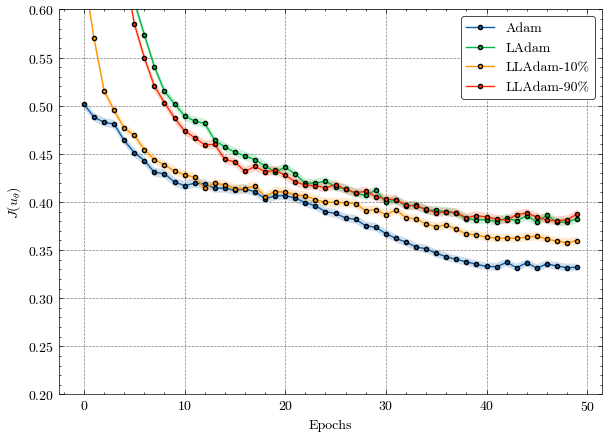

In [23]:
plot_langevin_loss(
    test_loss_adam,
    test_ci_adam,
    test_loss_ladam,
    test_ci_ladam,
    [test_loss_ll10adam, test_loss_ll90adam],
    [test_ci_ll10adam, test_ci_ll90adam],
    ll=[10, 90],
    name="Adam",
    ylim=(0.2, 0.6),
)

In [24]:
ocp = Fishing(**model_config)
ocp.set_control(control_config, multiple_controls=True)
adadelta = [
    optim.Adadelta(control.parameters(), lr=5e-1, rho=0.95) for control in ocp.control
]
scheduler = [
    PiecewiseConstantScheduler(opt, target_lr=5e-2, target_sigma=0, total_iters=40)
    for opt in adam
]
epochs = 50

train_loss_adadelta, test_loss_adadelta, test_ci_adadelta = train(
    ocp,
    adadelta,
    scheduler,
    "Adadelta",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
)

Fishing: Epoch 49, Adadelta, lr=0.050, sigma=[0], train=0.463, test=0.460: 100%|██████████| 50/50 [00:07<00:00,  6.32it/s]


In [25]:
ocp = Fishing(**model_config)
ocp.set_control(control_config, multiple_controls=True)
ladadelta = [
    LAdadelta(control.parameters(), lr=5e-1, sigma=5e-3) for control in ocp.control
]
scheduler = [
    PiecewiseConstantScheduler(opt, target_lr=5e-2, target_sigma=0, total_iters=40)
    for opt in adam
]

train_loss_ladadelta, test_loss_ladadelta, test_ci_ladadelta = train(
    ocp,
    ladadelta,
    scheduler,
    "LAdadelta",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
)

Fishing: Epoch 49, LAdadelta, lr=0.050, sigma=[0], train=0.414, test=0.410: 100%|██████████| 50/50 [00:08<00:00,  6.04it/s]


In [26]:
ocp = Fishing(**model_config)
ocp.set_control(control_config, multiple_controls=True)
ll = 10  # Langevin Layer percentage
lladadelta = []
for i, control in enumerate(ocp.control):
    if 100 * (i + 1) / len(ocp.control) <= ll:
        lladadelta.append(LAdadelta(control.parameters(), lr=5e-1, sigma=5e-3))
    else:
        lladadelta.append(optim.Adadelta(control.parameters(), lr=5e-1, rho=0.95))
scheduler = [
    PiecewiseConstantScheduler(opt, target_lr=5e-2, target_sigma=0, total_iters=40)
    for opt in lladadelta
]
epochs = 50

train_loss_ll10adadelta, test_loss_ll10adadelta, test_ci_ll10adadelta = train(
    ocp,
    lladadelta,
    scheduler,
    "LLAdadelta",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
)

Fishing: Epoch 49, LLAdadelta, lr=0.050, sigma=[0], train=0.457, test=0.453: 100%|██████████| 50/50 [00:07<00:00,  6.61it/s]


In [27]:
ocp = Fishing(**model_config)
ocp.set_control(control_config, multiple_controls=True)
ll = 90  # Langevin Layer percentage
lladadelta = []
for i, control in enumerate(ocp.control):
    if 100 * (i + 1) / len(ocp.control) <= ll:
        lladadelta.append(LAdadelta(control.parameters(), lr=5e-1, sigma=5e-3))
    else:
        lladadelta.append(optim.Adadelta(control.parameters(), lr=5e-1, rho=0.95))
scheduler = [
    PiecewiseConstantScheduler(opt, target_lr=5e-2, target_sigma=0, total_iters=40)
    for opt in lladadelta
]
epochs = 50

train_loss_ll90adadelta, test_loss_ll90adadelta, test_ci_ll90adadelta = train(
    ocp,
    lladadelta,
    scheduler,
    "LLAdadelta",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
)

Fishing: Epoch 49, LLAdadelta, lr=0.050, sigma=[0], train=0.413, test=0.419: 100%|██████████| 50/50 [00:07<00:00,  6.26it/s]


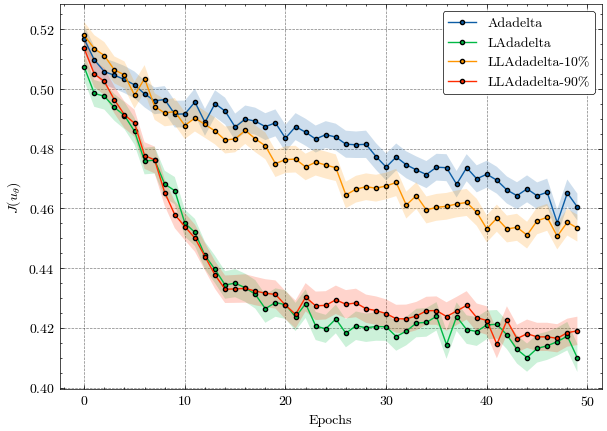

In [28]:
plot_langevin_loss(
    test_loss_adadelta,
    test_ci_adadelta,
    test_loss_ladadelta,
    test_ci_ladadelta,
    [test_loss_ll10adadelta, test_loss_ll90adadelta],
    [test_ci_ll10adadelta, test_ci_ll90adadelta],
    ll=[10, 90],
    name="Adadelta",
)

### Sample trajectory:

In [29]:
dim = 5

model_config = dict(
    T=1.0,
    N_euler=50,
    dim=dim,
    r=2 * torch.ones(dim),
    kappa=torch.Tensor(
        [
            [1.2, -0.1, 0.0, 0.0, -0.1],
            [0.2, 1.2, 0.0, 0.0, -0.1],
            [0.0, 0.2, 1.2, -0.1, 0.0],
            [0.0, 0.0, 0.1, 1.2, 0.0],
            [0.1, 0.1, 0.0, 0.0, 1.2],
        ]
    ),
    X_d=torch.ones(dim),
    u_m=0.01,
    u_M=1.0,
    alpha=0.01 * torch.ones(dim),
    beta=0.1,
    sigma=0.1 * torch.eye(dim),
    init_mean=torch.ones(dim),
    init_std=0.5,
    init_lbound=0.2,
    init_ubound=2,
)

control_config = dict(
    input_dim=1 + dim,
    output_dim=dim,
    hidden_dim=32,
    depth=2,
    activation=nn.ReLU(),
    out_transform=nn.Sigmoid(),
)

In [30]:
ocp = Fishing(**model_config)
ocp.set_control(control_config, multiple_controls=False)
adam = optim.Adam(ocp.control.parameters(), lr=2e-3)
scheduler = PiecewiseConstantScheduler(
    adam, target_lr=2e-4, target_sigma=0, total_iters=40
)

train_loss_adam, test_loss_adam, test_ci_adam = train(
    ocp, adam, scheduler, "Adam", epochs, train_size, test_size, train_batch, test_batch
)

Fishing: Epoch 49, Adam, lr=0.000, sigma=[0], train=0.321, test=0.323: 100%|██████████| 50/50 [00:17<00:00,  2.82it/s]


In [39]:
X, u = ocp.sample_traj(1)

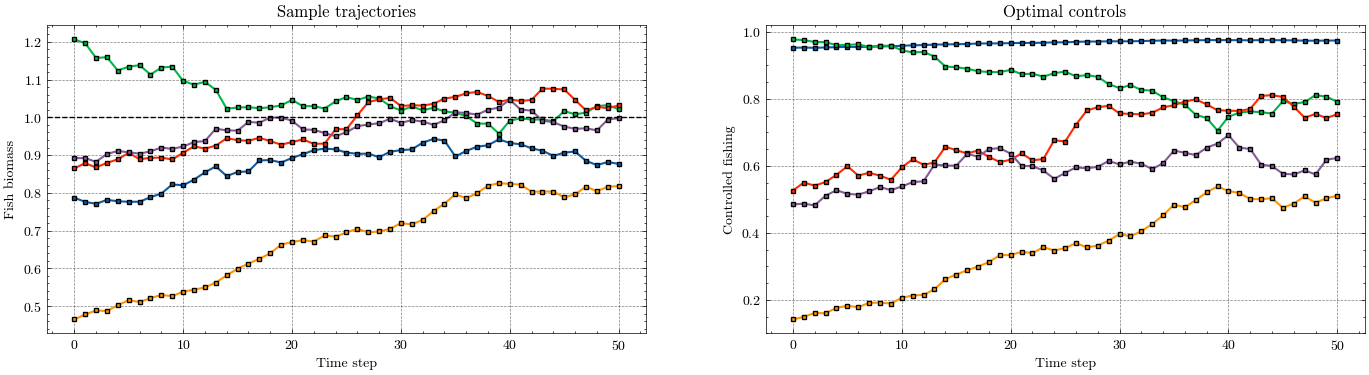

In [45]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(17, 4))

for k in range(X.shape[2]):
    ax1.plot(X[:, :, k].flatten().detach().numpy(), lw=1.5, marker="s", mec="k", ms=3)
    ax2.plot(u[:, :, k].flatten().detach().numpy(), lw=1.5, marker="s", mec="k", ms=3)
ax1.axhline(1, linestyle="--", color="k")
ax1.set_title("Sample trajectories")
ax1.set_xlabel("Time step")
ax1.set_ylabel("Fish biomass")
ax2.set_title("Optimal controls")
ax2.set_xlabel("Time step")
ax2.set_ylabel("Controlled fishing")
# fig.savefig("graphs/fishing/Sample_traj_fishing_N50.pdf")
plt.show()
plt.close()